# Construire une vérité terrain pour cartographier des objets par deep-learning

L'objectif de ce notebook est de vous guider dans la construction d'un jeu de données **(images, labels)**, pouvant servir de vérité terrain à un modèle de deep-learning pour la détection d'objets dans des photographies aériennes ou satellitaires. Ce jeu de données est créé à partir d'images géolocalisées (*fichiers rasters*) et de fichiers de géométries (*fichiers vecteurs*). 

Les données utilisées dans ce notebook sont sous license ouverte et proviennent de la plateforme des données de la Métropole de Lyon :
- [orthophotographies 2018](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)
- [emprise des bâtiments](https://data.grandlyon.com/jeux-de-donnees/batiments-metropole-lyon/ressources)
- [parcs et jardins](https://data.grandlyon.com/jeux-de-donnees/parcs-jardins-commune-lyon-v1-0-0/donnees)


Structure de nos données de départ : 

```
data
├── rasters
│   ├── 1843_5174_08_CC46.tif
│   ├── 1844_5173_08_CC46.tif
├── vectors
│   ├── buildings.json
│   ├── vegetation.json
├── categories.json
```

Les étapes nécessaires à la construction de cette vérité terrain correspondent aux fonction disponibles dans le module **`geolabels`** de notre bibliothèque [`geolabel_maker`]() : 

**1. Création des labels à partir des fichiers de géométries** :-> `make_labels()`

**2. Création des fichiers vrt** :-> `make_rasters()`

**3. Création de vignettes 256x256 pixels** :-> `make_tiles()`

**4. Création du fichier d'annotations** :-> `make_annotations()`

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

sys.path.append("../")

In [ ]:
# Imports basiques
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from shapely.geometry import box
import geopandas as gpd
import json

In [4]:
# Pour Windows: 
# Certaines erreurs peuvent survenir en utilisant shapely.
# Désactiver `speedups` permet de résoudre ce problème.
from geolabel_maker import speedups
from geolabel_maker import Dataset

speedups.disable()

In [5]:
# Definition des variables
ROOT = "../data"
DIR_IMAGES = f"{ROOT}/images"
DIR_CATEGORIES = f"{ROOT}/categories"

## 0. Visualisation des données

Avant de préparer nos données pour les algorithmes de deep-learning, commençons par en visualiser le contenu.

### Visualisation des images

Pour visualiser les photographies à notre disposition, nous utilisons simplement la bibliothèque de gestion d'images de Python ([PIL](https://he-arc.github.io/livre-python/pillow/index.html)) et la fonction `imshow()` de Matplotlib.

In [6]:
# Liste des fichiers images à notre disposition
images = list(Path(DIR_IMAGES).iterdir())
print(f"Il y a {len(images)} images.")

Il y a 2 images.


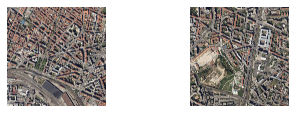

In [7]:
# Visualisation des images
figure = plt.figure()
columns = 2

for i, image_file in enumerate(images):
    image = rasterio.open(image_file)
    image = image.read().transpose((1, 2, 0))
    plt.subplot(int(len(images)/columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

On peut aussi accéder aux caractéristiques spatiales des images avec la bibliothèque [rasterio](https://rasterio.readthedocs.io/en/latest/). Ici, nous sauvegardons les emprises spatiales des images pour les visualiser en même temps que les géométries dont nous disposons. 

In [8]:
# Sauvegarde de l'emprise spatiale des images
images_xy = []

for image_file in images :
    image_data = rasterio.open(image_file)
    coordinate = image_data.bounds
    image_bbox = box(*coordinate)
    images_xy.append(image_bbox.exterior.xy)

### Visualisation des géométries

Pour visualiser les géométries, nous utilisons [geopandas](https://geopandas.org/index.html), une bibliothèque de gestion de données spatiales vectorielles. Le contenu de chaque fichier sera représenté par une couleur que nous définissons ci-dessus. La liste `colors` doit contenir autant de couleurs qu'il n'y a de fichiers dans le dossier `data/vectors/`.

In [9]:
# Définition des couleurs à utiliser pour représenter les différents types de données
# gris --> 1er fichier = bâtiments
# vert --> 2d fichier = végétation
colors = ["#92a9a2", "green"]

In [10]:
# Liste des fichiers de géométries à notre disposition
vectors = list(Path(DIR_CATEGORIES).iterdir())

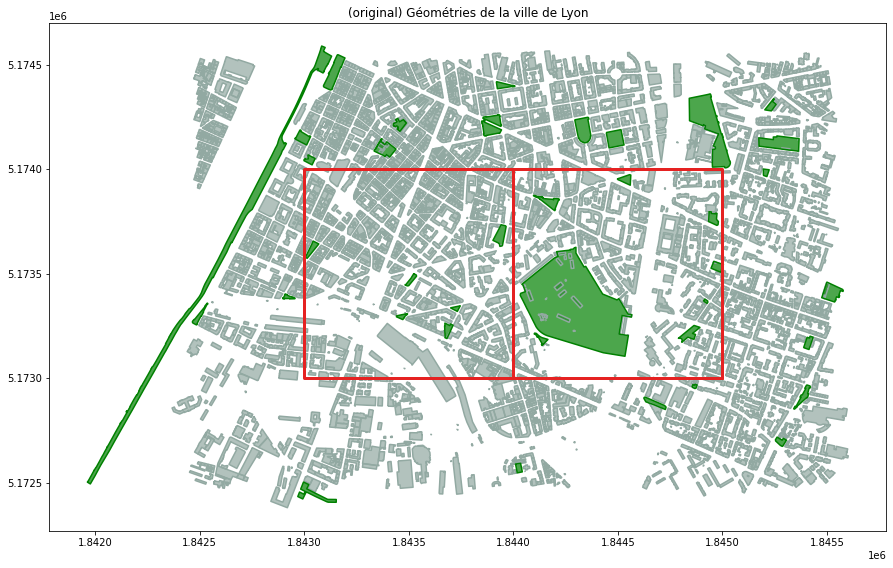

In [11]:
# Charge les coordonnées d'une des images
crs = rasterio.open(images[0]).crs

# Visualisation des fichiers vecteurs.
fig, ax = plt.subplots(figsize=(15, 15))

for vector_file, color in zip(vectors, colors) :
    # Lecture du fichier vecteur
    vector_data = gpd.read_file(vector_file)    
    # Conversion du systeme de coordonnées pour que toutes les géométries
    # soient dans le même système que les coordonnées des images.
    vector_data = vector_data.to_crs(crs)
    vector_data.plot(color=color, alpha=0.7, ax=ax)
    vector_data.boundary.plot(edgecolor=color, ax=ax)

# Les emprises des images sont représentées par un carré rouge.
for x,y in images_xy :
    ax.plot(x, y, color='#e52222',
        linewidth=3, solid_capstyle='round')
    
plt.title("(original) Géométries de la ville de Lyon")
plt.show()

## 1. Création des labels à partir des fichiers de géométries

A partir des données que nous venons de représenter, nous allons tout d'abord créer des images "label" contenant la représentation des géométries dont nous disposons et dont l'emprise correspond à chaque fichier image disponible.

Pour cela, nous allons préciser les fichiers de géométries que nous voulons utiliser, le nom de la catégorie d'objets à laquelle ils correspondent, ainsi que leur couleur de représentation dans un fichier json de configuration. Ce fichier doit suivre la structure suivante :
```
{
  "name_of_category": {
    "id": 0,
    "file": categories/your_category_file,
    "color": [255, 255, 255]
  },
}
```
Il se compose d'un bloc d'informations par fichier / catégorie d'objets. A l'intérieur de ces blocs, chaque information doit être unique, en particulier l'identifiant (`id`) et le triplet RGB (`color`) renseignant la couleur à utiliser.

In [6]:
# Import des modules de geolabel_maker
from geolabel_maker import Dataset

dataset = Dataset.open("../data")
dataset

Loading Categories: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


Dataset(
  (root): '..\data'
  (filename): '..\data\dataset.json'
  (dir_images): '..\data\images'
  (dir_categories): '..\data\categories'
  (dir_labels): '..\data\labels'
  (images): RasterCollection(
    (0): Raster(filename='..\data\images\1843_5173_08_CC46.tif', bbox=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='..\data\images\1844_5173_08_CC46.tif', bbox=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=Color(red=255, green=255, blue=255))
    (1): Category(data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=Color(red=0, green=255, blue=0))
  )
  (labels): RasterCollection(
    (0): Raster(filename='..\data\labels\1843_5173_08_CC46-label.tif', bbox=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='..\data\labels\1844_5173_08_CC46-label.tif', bbox=(1844000.0, 

Les images "labels" sont créées en appelant la méthode `generate_labels()`.

In [7]:
dataset.generate_labels()

Generating Labels:   0%|                                                                         | 0/2 [01:38<?, ?it/s]


CPLE_AppDefinedError: Deleting ..\data\labels\1843_5173_08_CC46-label.tif failed: Permission denied

### Visualisation du résultat

Nous pouvons d'ors-et-déjà regarder ici le résultat de la labellisation avec la fonction `show()` disponible dans le module `labels`. Cette étape donne aussi un premier aperçu de la précision de la labellisation.

Il est possible d'obtenir une visualisation plus précise en diminuant la taille (en pixels) de la zone comparée. La partie de l'image sélectionnée est alors choisie ***aléatoirement*** à chaque appel de la fonction.

## 2. Création des fichiers vrt

Les images et les labels doivent ensuite être regroupés dans un fichier [VRT](https://gdal.org/drivers/raster/vrt.html) pour permettre le découpage en vignettes. Cette étape est réalisée avec la fonction `generate_vrt()`.

In [17]:
rasters_vrt, labels_vrt = dataset.generate_vrt()

Ces regroupements peuvent être visualisés directement avec les fonctions de la bibliothèque `rasterio`.

In [ ]:
raster_images_vrt = rasterio.open(images_vrt)
raster_labels_vrt = rasterio.open(labels_vrt)

fig, (ax_img, ax_label) = plt.subplots(2,1, figsize=(15,15))

rasterio.plot.show(raster_images_vrt, title="Images", ax=ax_img)
ax_img.axis('off')
rasterio.plot.show(raster_labels_vrt, title="Label", ax=ax_label)
ax_label.axis('off')

raster_images_vrt.close()
raster_labels_vrt.close()

## 3. Création de vignettes 256x256 pixels

Nous pouvons maintenant découper les images et labels dont nous disposons en vignettes de 256x256 pixels. Pour cela, nous créons des tuiles raster à différents niveaux de zoom. 

Avant de lancer cette étape, il est nécessaire de créer un répertoire où seront stockées les vignettes.

Cette étape est réalisée avec la fonction `make_tiles()`.

In [18]:
dataset.generate_tiles(zoom="17-18")

Generating image tiles at ..\data\tiles\images
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating label tiles at ..\data\tiles\labels
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


'..\\data\\tiles'

Les tuiles sont organisées dans les répertoires `images` et `labels`, et visibles dans un navigateur web grâce aux fichiers `openlayers.html`.

Structure des données créées : 

```
data
├── categories
│   ├── buildings.json
│   ├── vegetation.json
├── images
│   ├── 1843_5174_08_CC46.tif
│   ├── 1844_5173_08_CC46.tif
├── labels
│   ├── 1843_5174_08_CC46-label.tif
│   ├── 1844_5173_08_CC46-label.tif
├── tiles
│   ├── images
│   │    ├── 13
│   │    │   ├── 4206
│   │    │   |   ├── 5269.png
│   │    ├── 14
│   │    ├── openlayers.html
│   │    ├── tilemapresource.xml
│   ├── labels
│   │    ├── 13
│   │    │   ├── 4206
│   │    │   │   ├── 5269.png
│   │    ├── 14
│   │    ├── openlayers.html
│   │    ├── tilemapresource.xml
├── categories.json
├── images.vrt
├── labels.vrt
```

![](../medias/openlayers.jpg)

## 4. Création du fichier d'annotations

Enfin, pour certains modèles, il est nécessaire de fournir un fichier descriptif complémentaire au jeu de données. La fonction `make_annotations()` génére un fichier json au format [COCO](http://cocodataset.org/#home).

In [19]:
# Import des modules de geolabel_maker
from geolabel_maker.annotations import COCO

coco = COCO.build("../data/tiles/images/17", "../data/tiles/labels/17", dataset.categories, pattern="*.png")

In [16]:
dataset.categories

CategoryCollection(
  (0): Category(name='buildings', data=GeoDataFrame(..., length=6130), color=(255, 255, 255))
  (1): Category(name='vegetation', data=GeoDataFrame(..., length=38), color=(0, 255, 0))
)

In [20]:
from geolabel_maker.annotations.functional import *

extract_categories("../data/tiles/labels/17/67301/84309.png", dataset.categories)

[Category(name='buildings', data=GeoDataFrame(..., length=22), color=(255, 255, 255)),
 Category(name='vegetation', data=GeoDataFrame(..., length=2), color=(0, 255, 0))]

Pour sauvegarder les annotations créées, il suffit de les sauvegarder via le package ``json``.

In [21]:
with open("annotations.json", "w") as f:
    json.dump(coco.to_dict(), f, indent=2)

Pour contrôler ce fichier, nous vous proposons d'utiliser le notebook [Check_coco_annotations.ipynb]().